In [2]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from feature_engine.imputation import RandomSampleImputer

In [3]:
raw = pd.read_csv('accepted_2007_to_2018Q4.csv')

C:\Users\i99ks\AppData\Local\Temp\ipykernel_9340\4141700990.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv('accepted_2007_to_2018Q4.csv')


In [16]:

# =======================================================================
# 주제: 2015 ~ 2016 대출이 실행된 대상자에 대한 정상/불량 예측 모형 개발
# =======================================================================
# < 대상자 선정 및 타겟 정의 >

data = raw.drop(raw.columns[[1,6,8,9,17,22,27,28,51,52,116,117,
                             57,58,59,63,64,65,66,67,68,69,70,71,72,73
                             ,75,76,77,90,92,115
                             ,118,119,120,121,122,123,124,125,126,127
                             ,129,130,131,132,133,134,135,136,137,138,139,140,141,142
                             ,145,146,147,148,149,150]], axis = 1)                          # 모형 제외 항목 및 결측치 많은 변수 drop
data = data[(data['issue_d'].str[-4:] == '2015')|(data['issue_d'].str[-4:] == '2016')]      # 대출실행년월이 2015 ~ 2016년인 대상자
data = data[(data['loan_status']=='Current')
      |(data['loan_status']=='Fully Paid')
      |(data['loan_status']=='Charged Off') 
      |(data['loan_status']=='Default')
      |(data['loan_status']=='Late (16-30 days)')
      |(data['loan_status']=='Late (31-120 days)')
      ]                                                         # Current / Fully Paid / Charged Off / Default / Late (16-30 days) / Late (31-120 days) 에 해당하는 대상자 (그 외 값은 제거)
data = data.replace(['Current','Fully Paid'],0).replace(['Charged Off','Default','Late (16-30 days)','Late (31-120 days)'],1)       # 타겟 정의 [정상 (0) / 불량 (1)]
data = data.loc[data.application_type == 'Individual']          # Individual 인 대상자

data = data.drop('application_type', axis = 1)

# data['issue_d'].str[-4:]                     #check
# data['loan_status'].value_counts()           #check
# data['issue_d'].value_counts()               #check
# data['application_type'].value_counts()      #check
# data.value_counts()                          #check
# print(data['id'].duplicated(keep=False).sum())    # id 중복 체크 / result: 0
# =======================================================================

# =======================================================================
# DATA PREPROCESSING
# =======================================================================

# loan_amnt / funded_amnt / funded_amnt_inv -> loan_amnt 만 사용
data = data.drop(['funded_amnt','funded_amnt_inv'], axis = 1)

# issue_d
data['issue_d_month'] = data['issue_d'].str[0:3]
data['issue_d_year'] = data['issue_d'].str[-4:].apply(pd.to_numeric)
data = data.drop('issue_d', axis = 1)


# emp_length 
data = data.replace('< 1 year',0).replace('1 year',1).replace('2 years',2).replace('3 years',3).replace('4 years',4).replace('5 years',5).replace('6 years',6).replace('7 years',7).replace('8 years',8).replace('9 years',9).replace('10+ years',10)

# emp NA imputation (random sample imputation)
data['emp_length_imputed'] = data['emp_length'].copy()
random_sample_train = data['emp_length'].dropna().sample(data['emp_length'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['emp_length'].isnull()].index
data.loc[data['emp_length'].isnull(),'emp_length_imputed'] = random_sample_train

data['emp_title_imputed'] = data['emp_title'].copy()
random_sample_train = data['emp_title'].dropna().sample(data['emp_title'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['emp_title'].isnull()].index
data.loc[data['emp_title'].isnull(),'emp_title_imputed'] = random_sample_train

data = data.drop(['emp_length','emp_title'], axis = 1)
data = data.rename(columns={'emp_length_imputed':'emp_length','emp_title_imputed':'emp_title'})

# url drop
data = data.drop('url', axis = 1)

# desc drop
data = data.drop('desc', axis = 1)

# title NA imputation
data['title_imputed'] = data['title'].copy()
random_sample_train = data['title'].dropna().sample(data['title'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['title'].isnull()].index
data.loc[data['title'].isnull(),'title_imputed'] = random_sample_train

data = data.drop('title', axis = 1)
data = data.rename(columns={'title_imputed':'title'})

# earliest_cr_line
data['earliest_cr_line_month'] = data['earliest_cr_line'].str[0:3]
data['earliest_cr_line_year'] = data['earliest_cr_line'].str[-4:].apply(pd.to_numeric)
data = data.drop('earliest_cr_line', axis = 1)

# inq_last_6mths NA delete
data = data[~data['inq_last_6mths'].isnull()]

# mths_since_last ~ variables delete
data = data.drop(['mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog'], axis = 1)
 
# last_pymnt_d NA imputation
data['last_pymnt_d_imputed'] = data['last_pymnt_d'].copy()
random_sample_train = data['last_pymnt_d'].dropna().sample(data['last_pymnt_d'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['last_pymnt_d'].isnull()].index
data.loc[data['last_pymnt_d'].isnull(),'last_pymnt_d_imputed'] = random_sample_train

data = data.drop('last_pymnt_d', axis = 1)
data = data.rename(columns={'last_pymnt_d_imputed':'last_pymnt_d'})

# last_pymnt_d
data['last_pymnt_d_month'] = data['last_pymnt_d'].str[0:3]
data['last_pymnt_d_year'] = data['last_pymnt_d'].str[-4:].apply(pd.to_numeric)
data = data.drop('last_pymnt_d', axis = 1)

# next_pymnt_d delete
data = data.drop('next_pymnt_d', axis = 1)

# last_credit_pull_d NA imputation
data['last_credit_pull_d_imputed'] = data['last_credit_pull_d'].copy()
random_sample_train = data['last_credit_pull_d'].dropna().sample(data['last_credit_pull_d'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['last_credit_pull_d'].isnull()].index
data.loc[data['last_credit_pull_d'].isnull(),'last_credit_pull_d_imputed'] = random_sample_train

data = data.drop('last_credit_pull_d', axis = 1)
data = data.rename(columns={'last_credit_pull_d_imputed':'last_credit_pull_d'})

# last_credit_pull_d
data['last_credit_pull_d_month'] = data['last_credit_pull_d'].str[0:3]
data['last_credit_pull_d_year'] = data['last_credit_pull_d'].str[-4:].apply(pd.to_numeric)
data = data.drop('last_credit_pull_d', axis = 1)

# revol_util NA imputation
data['revol_util_imputed'] = data['revol_util'].copy()
random_sample_train = data['revol_util'].dropna().sample(data['revol_util'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['revol_util'].isnull()].index
data.loc[data['revol_util'].isnull(),'revol_util_imputed'] = random_sample_train

data = data.drop('revol_util', axis = 1)
data = data.rename(columns={'revol_util_imputed':'revol_util'})

# bc_open_to_buy NA imputation
data['bc_open_to_buy_imputed'] = data['bc_open_to_buy'].copy()
random_sample_train = data['bc_open_to_buy'].dropna().sample(data['bc_open_to_buy'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['bc_open_to_buy'].isnull()].index
data.loc[data['bc_open_to_buy'].isnull(),'bc_open_to_buy_imputed'] = random_sample_train

data = data.drop('bc_open_to_buy', axis = 1)
data = data.rename(columns={'bc_open_to_buy_imputed':'bc_open_to_buy'})

# bc_util NA imputation
data['bc_util_imputed'] = data['bc_util'].copy()
random_sample_train = data['bc_util'].dropna().sample(data['bc_util'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['bc_util'].isnull()].index
data.loc[data['bc_util'].isnull(),'bc_util_imputed'] = random_sample_train

data = data.drop('bc_util', axis = 1)
data = data.rename(columns={'bc_util_imputed':'bc_util'})

# mo_sin_old_il_acct NA imputation
data['mo_sin_old_il_acct_imputed'] = data['mo_sin_old_il_acct'].copy()
random_sample_train = data['mo_sin_old_il_acct'].dropna().sample(data['mo_sin_old_il_acct'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['mo_sin_old_il_acct'].isnull()].index
data.loc[data['mo_sin_old_il_acct'].isnull(),'mo_sin_old_il_acct_imputed'] = random_sample_train

data = data.drop('mo_sin_old_il_acct', axis = 1)
data = data.rename(columns={'mo_sin_old_il_acct_imputed':'mo_sin_old_il_acct'})

# mths_since_recent_bc NA imputation
data['mths_since_recent_bc_imputed'] = data['mths_since_recent_bc'].copy()
random_sample_train = data['mths_since_recent_bc'].dropna().sample(data['mths_since_recent_bc'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['mths_since_recent_bc'].isnull()].index
data.loc[data['mths_since_recent_bc'].isnull(),'mths_since_recent_bc_imputed'] = random_sample_train

data = data.drop('mths_since_recent_bc', axis = 1)
data = data.rename(columns={'mths_since_recent_bc_imputed':'mths_since_recent_bc'})

# mths_since_recent_inq NA imputation
data['mths_since_recent_inq_imputed'] = data['mths_since_recent_inq'].copy()
random_sample_train = data['mths_since_recent_inq'].dropna().sample(data['mths_since_recent_inq'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['mths_since_recent_inq'].isnull()].index
data.loc[data['mths_since_recent_inq'].isnull(),'mths_since_recent_inq_imputed'] = random_sample_train

data = data.drop('mths_since_recent_inq', axis = 1)
data = data.rename(columns={'mths_since_recent_inq_imputed':'mths_since_recent_inq'})

# num_tl_120dpd_2m NA imputation
data['num_tl_120dpd_2m_imputed'] = data['num_tl_120dpd_2m'].copy()
random_sample_train = data['num_tl_120dpd_2m'].dropna().sample(data['num_tl_120dpd_2m'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['num_tl_120dpd_2m'].isnull()].index
data.loc[data['num_tl_120dpd_2m'].isnull(),'num_tl_120dpd_2m_imputed'] = random_sample_train

data = data.drop('num_tl_120dpd_2m', axis = 1)
data = data.rename(columns={'num_tl_120dpd_2m_imputed':'num_tl_120dpd_2m'})

# percent_bc_gt_75 NA imputation
data['percent_bc_gt_75_imputed'] = data['percent_bc_gt_75'].copy()
random_sample_train = data['percent_bc_gt_75'].dropna().sample(data['percent_bc_gt_75'].isnull().sum(), random_state = 18)
random_sample_train.index = data[data['percent_bc_gt_75'].isnull()].index
data.loc[data['percent_bc_gt_75'].isnull(),'percent_bc_gt_75_imputed'] = random_sample_train

data = data.drop('percent_bc_gt_75', axis = 1)
data = data.rename(columns={'percent_bc_gt_75_imputed':'percent_bc_gt_75'})

0

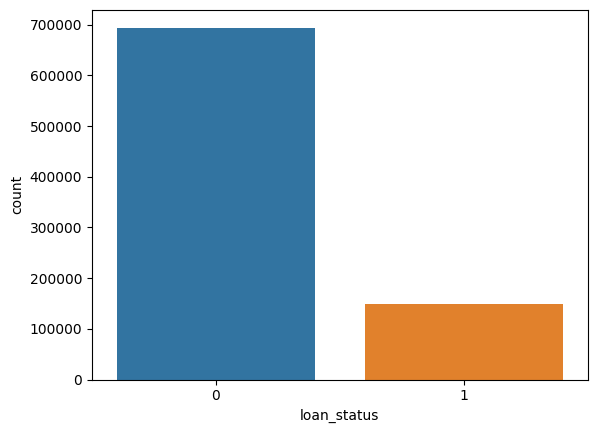

In [214]:

# target variable countplot
sns.countplot(x = 'loan_status', data=data)
data['loan_status'].isnull().sum()

In [98]:
# amnt corr
# data[['loan_amnt','funded_amnt','funded_amnt_inv']].corr()
#sns.heatmap(data[['loan_amnt','funded_amnt','funded_amnt_inv']].corr(), annot=True)

,loan_amnt,funded_amnt,funded_amnt_inv
loan_amnt,1.000000,0.999999,0.999992
funded_amnt,0.999999,1.000000,0.999993
funded_amnt_inv,0.999992,0.999993,1.000000


<Axes: xlabel='term', ylabel='count'>

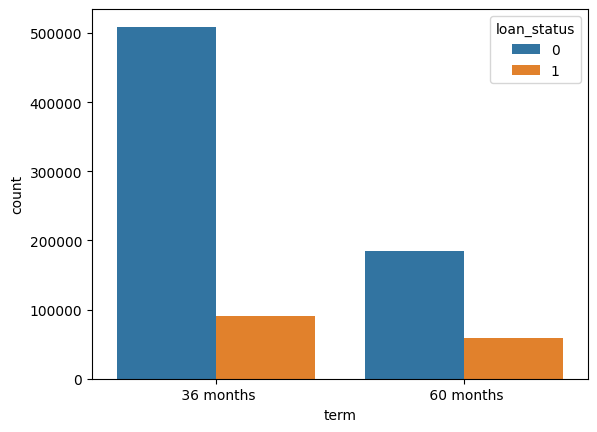

In [12]:
sns.countplot(x = 'term', data=data, hue = 'loan_status')

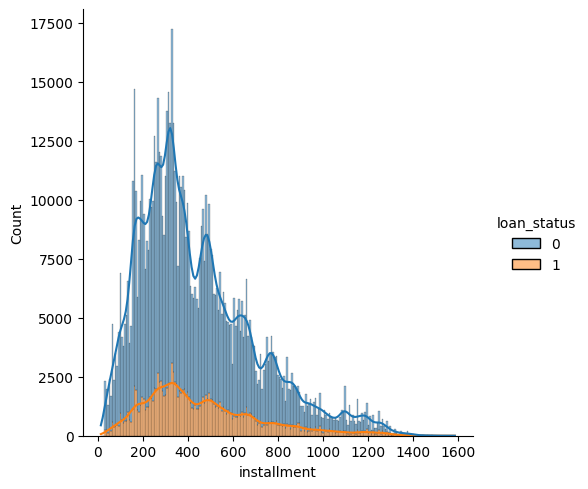

In [7]:
# installment distribution
sns.displot(x = data['installment'], kde = True, hue = 'loan_status', multiple = 'stack', data = data)

<BarContainer object of 100 artists>

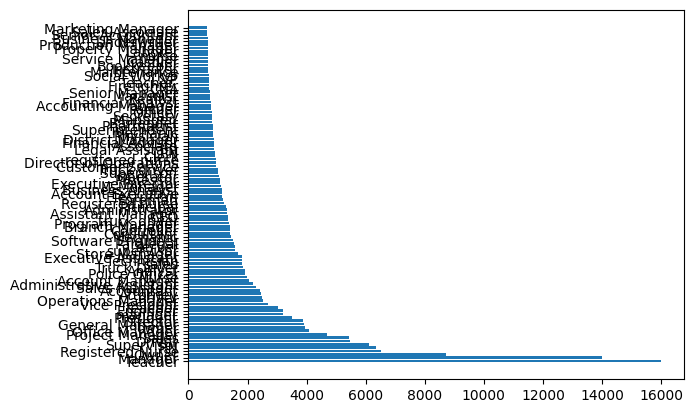

In [79]:
plt.barh(data.emp_title.value_counts()[:100].index, data.emp_title.value_counts()[:100])


In [ ]:
# Elbow curve 
emp_title = data[['emp_title','loan_status']]
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init=5)
    kmode.fit_predict(emp_title)
    #cost.append(kmode.cost_)
    
#plt.plot(K, cost, 'bx-')
#plt.xlabel('No. of clusters')
#plt.ylabel('Cost')
#plt.title('Elbow Method For Optimal k')
#plt.show()

0.0
0.0


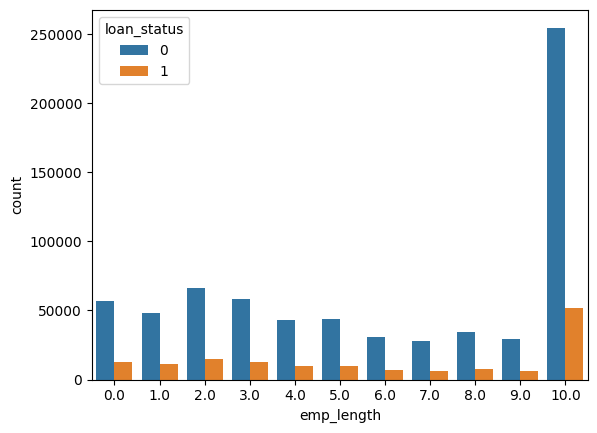

In [10]:
# emp_length
sns.countplot(x = 'emp_length', data=data, hue = 'loan_status')
print(data.emp_length.isnull().sum()/data.id.count())
print(data.emp_title.isnull().sum()/data.id.count())

0

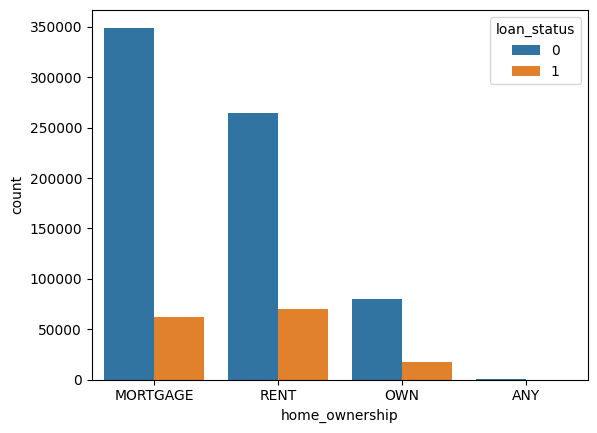

In [11]:

# home_ownership
sns.countplot(x = 'home_ownership', data=data, hue = 'loan_status')
data['home_ownership'].isnull().sum()

0

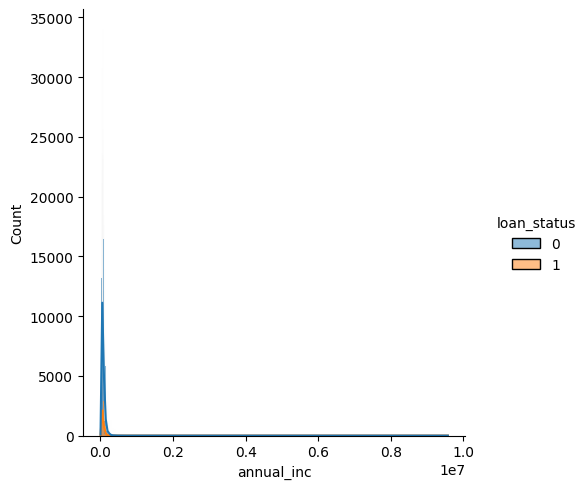

In [13]:

# Annual income
sns.displot(x = data['annual_inc'], kde = True, hue = 'loan_status', multiple = 'stack', data = data)
data['annual_inc'].isnull().sum()

0

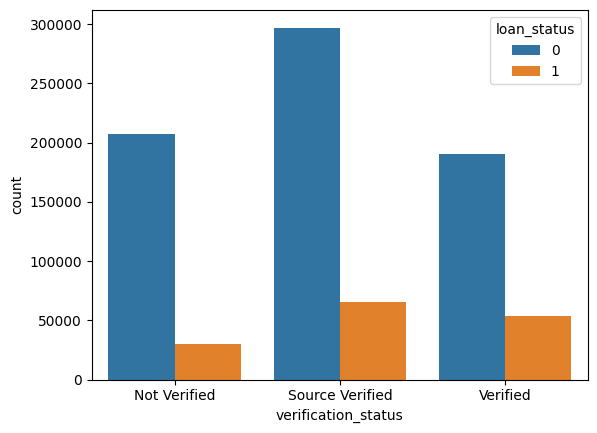

In [14]:

sns.countplot(x = 'verification_status', data=data, hue = 'loan_status')
data['verification_status'].isnull().sum()

In [141]:
# url = data['url'].str[:-7]
# url.value_counts()

# desc = data['desc'].drop_duplicates()

0

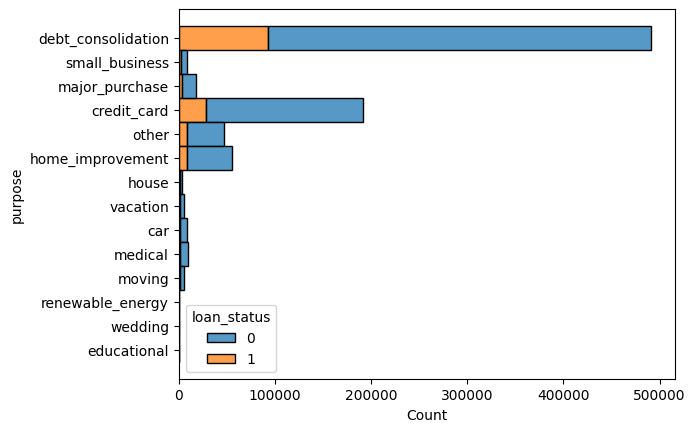

In [23]:
sns.histplot(y = data['purpose'], data = data, hue = 'loan_status', multiple = 'stack')
data['purpose'].isnull().sum()

0.0


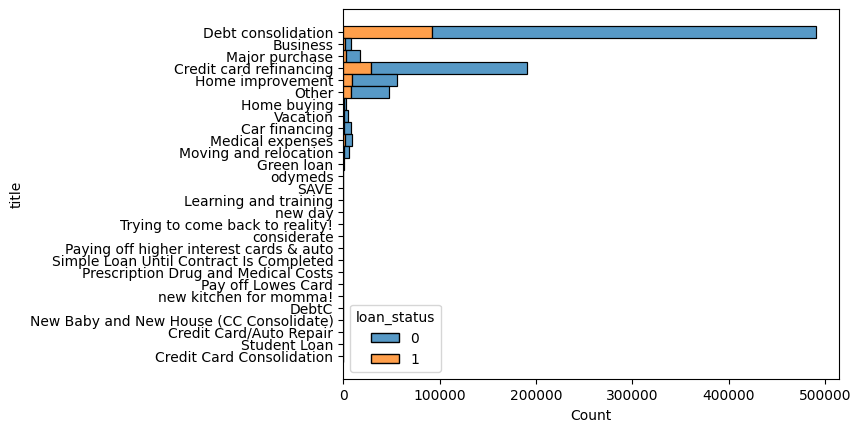

In [24]:
sns.histplot(y = data['title'], data = data, hue = 'loan_status', multiple = 'stack')
print(data.title.isnull().sum()/data.id.count())

0

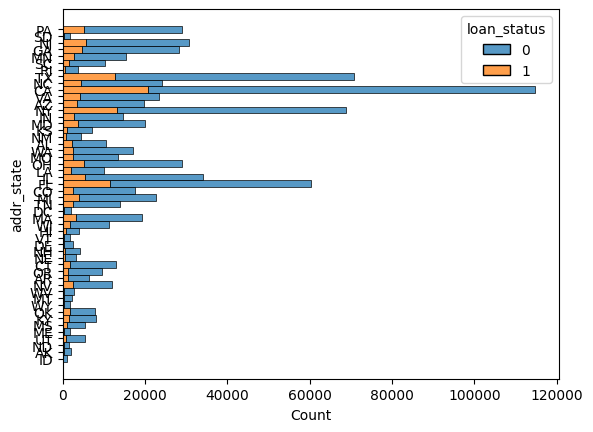

In [28]:

# addr_state
sns.histplot(y = data['addr_state'], data = data, hue = 'loan_status', multiple = 'stack')
#plt.barh(data.addr_state.value_counts().index, data.addr_state.value_counts())
data['addr_state'].isnull().sum()

0

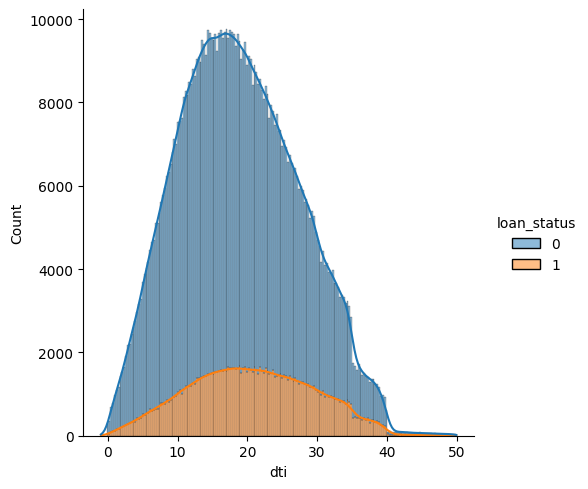

In [30]:

#dti
sns.displot(x = data['dti'], kde = True, hue = 'loan_status', multiple = 'stack', data = data)
data['dti'].isnull().sum()

0

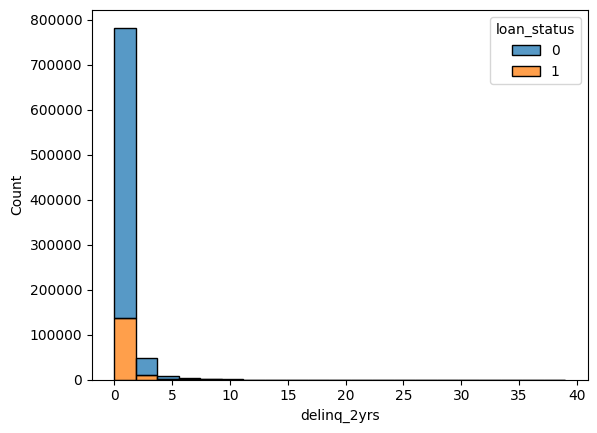

In [32]:
#delinq_2yrs
sns.histplot(x = 'delinq_2yrs', data=data, hue = 'loan_status', multiple = 'stack')
data['delinq_2yrs'].isnull().sum()

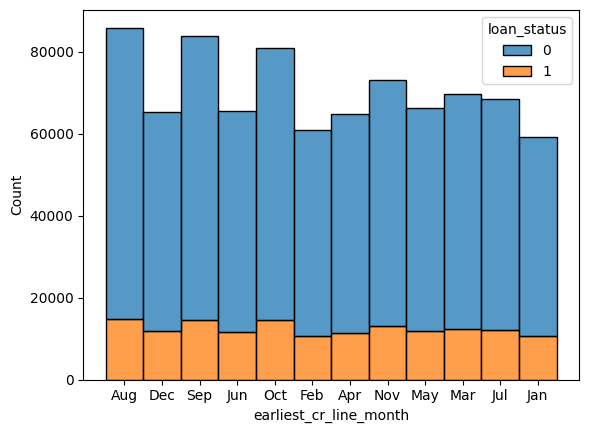

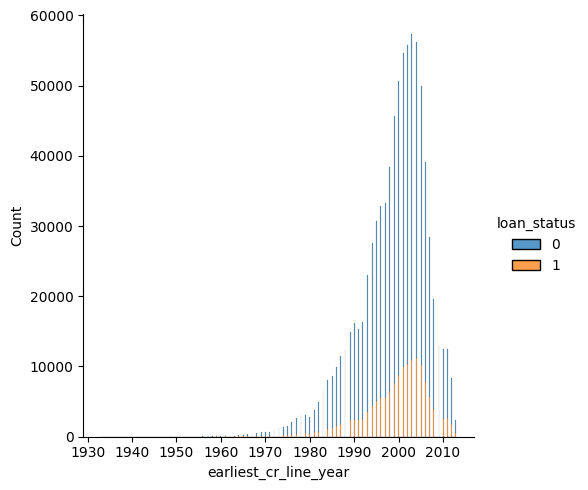

In [35]:
#earliest_cr_line
# earliest_cr_line = data['earliest_cr_line'].unique()
sns.histplot(x = 'earliest_cr_line_month', data=data, hue = 'loan_status', multiple = 'stack')
sns.displot(x = data['earliest_cr_line_year'], data = data, hue = 'loan_status', multiple = 'stack')


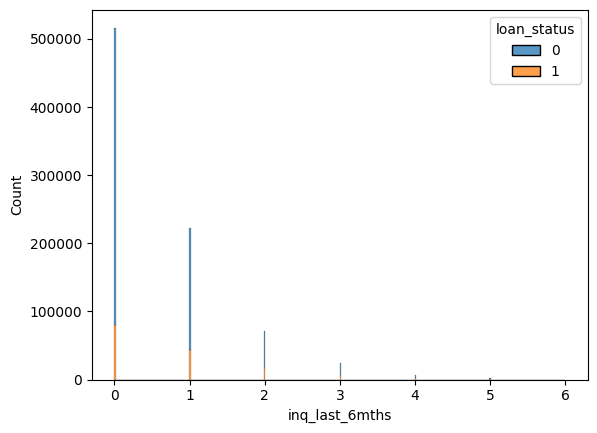

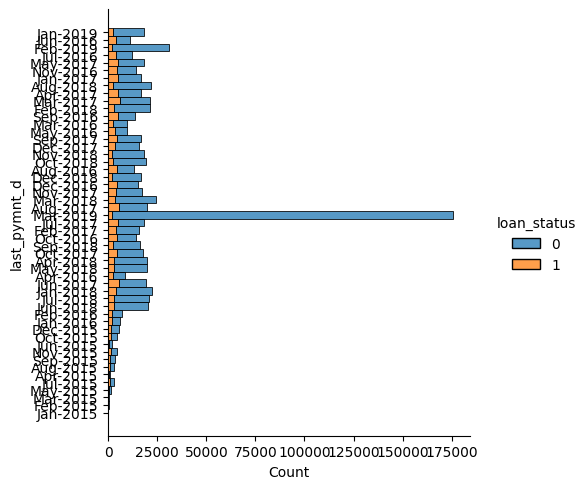

In [39]:
#inq_last_6mths
sns.histplot(x = 'inq_last_6mths', data=data, hue = 'loan_status', multiple = 'stack')

sns.displot(y = data['last_pymnt_d'], data = data, hue = 'loan_status', multiple = 'stack')

In [38]:
print(data['open_acc'].isnull().sum())
print(data['policy_code'].isnull().sum()/data.count())

0
id                        0.0
loan_amnt                 0.0
term                      0.0
installment               0.0
home_ownership            0.0
                         ... 
title                     0.0
earliest_cr_line_month    0.0
earliest_cr_line_year     0.0
last_pymnt_d              0.0
last_credit_pull_d        0.0
Length: 134, dtype: float64


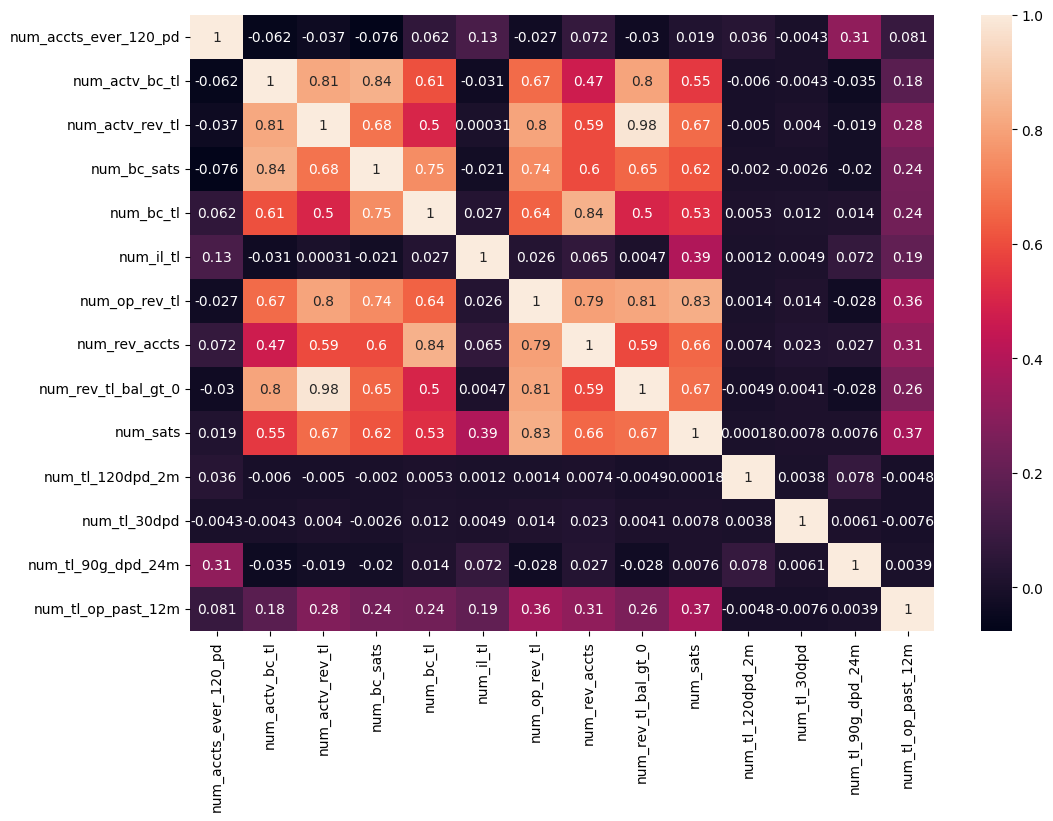

In [64]:
total_pymnt = data[['total_pymnt','total_pymnt_inv']]
total_pymnt.corr()

total_rec = data[['total_rec_prncp','total_rec_int','total_rec_late_fee']]
total_rec.corr()


open = data[['open_il_12m','open_rv_12m']]
open.corr()

num = data[['num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m']]
num.corr()
sns.heatmap(num.corr(), annot = True)
plt.gcf().set_size_inches(12,8)

In [15]:
NULL = data.isnull().sum()

data_dummies = pd.get_dummies(data = data, columns = ['term','home_ownership','verification_status','purpose','addr_state'])